In [1]:
import pandas as pd
from catboost import CatBoostClassifier

In [2]:
db = pd.read_csv("..//data//01_raw//train.csv")

In [5]:
db.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')

In [18]:
db[["group_id", "group_nbr"]] = db["PassengerId"].str.split("_", expand=True)
db[["Cabin_1", "Cabin_2", "Cabin_3"]] = db["Cabin"].str.split("/", expand=True)
db[["first_name", "last_name"]] = db["Name"].str.split(" ", expand=True)

In [20]:
# Create Number of persons in a group
group_count = db.groupby(by="group_id").size().reset_index(name="group_count")
# Create number of persons in a family
family_count = db.groupby(by="last_name").size().reset_index(name="family_size")
# Create number of persons in a cabin 
cabin_count = db.groupby(by="Cabin_1").size().reset_index(name="cabin_count")

db = db.merge(group_count, on="group_id", how="left")
db = db.merge(family_count, on="last_name", how="left")
db = db.merge(cabin_count, on="Cabin_1", how="left")

In [32]:
import plotly.express as px

fig = px.histogram(db, x="Age", color="Transported", barnorm="percent")
fig.show()

In [33]:

fig = px.bar(db, x="CryoSleep", color="Transported")
fig.show()

In [35]:
db["sum_of_fees"] = db["FoodCourt"] + db['ShoppingMall'] + db['Spa'] + db['VRDeck']

In [36]:
fig = px.histogram(db, x="sum_of_fees", color="Transported", barnorm="percent")
fig.show()

In [37]:
db.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported', 'group_id', 'group_nbr', 'Cabin_1', 'Cabin_2',
       'Cabin_3', 'first_name', 'last_name', 'group_count', 'family_size',
       'cabin_count', 'sum_of_fees'],
      dtype='object')

In [40]:
selected_columns = ["HomePlanet", "CryoSleep", "Destination", "Age", "VIP", "Cabin_1", "Cabin_3", 
                    "group_count", "family_size", "cabin_count", "sum_of_fees"]

In [41]:
X = db[selected_columns]
y = db["Transported"]

In [43]:
from sklearn.model_selection import train_test_split

In [48]:
X = X.fillna(-1)

In [49]:
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.80)

In [50]:
cat_feats = ["HomePlanet", "Destination", "Cabin_1", "Cabin_3"]

In [51]:
model = CatBoostClassifier(cat_features=cat_feats)
model.fit(x_train, y_train)

Learning rate set to 0.023581
0:	learn: 0.6825303	total: 314ms	remaining: 5m 13s
1:	learn: 0.6734490	total: 396ms	remaining: 3m 17s
2:	learn: 0.6657862	total: 501ms	remaining: 2m 46s
3:	learn: 0.6580672	total: 613ms	remaining: 2m 32s
4:	learn: 0.6490719	total: 711ms	remaining: 2m 21s
5:	learn: 0.6409947	total: 819ms	remaining: 2m 15s
6:	learn: 0.6345605	total: 933ms	remaining: 2m 12s
7:	learn: 0.6293110	total: 1.02s	remaining: 2m 6s
8:	learn: 0.6237050	total: 1.13s	remaining: 2m 4s
9:	learn: 0.6188178	total: 1.23s	remaining: 2m 1s
10:	learn: 0.6139473	total: 1.36s	remaining: 2m 2s
11:	learn: 0.6085987	total: 1.48s	remaining: 2m 1s
12:	learn: 0.6028291	total: 1.58s	remaining: 1m 59s
13:	learn: 0.5977495	total: 1.69s	remaining: 1m 59s
14:	learn: 0.5940902	total: 1.78s	remaining: 1m 56s
15:	learn: 0.5911064	total: 1.9s	remaining: 1m 56s
16:	learn: 0.5862816	total: 2.01s	remaining: 1m 56s
17:	learn: 0.5828734	total: 2.11s	remaining: 1m 55s
18:	learn: 0.5798240	total: 2.21s	remaining: 1m 54

In [52]:
from sklearn.metrics import roc_curve, f1_score, accuracy_score, precision_recall_curve, precision_score, recall_score

In [53]:
y_pred = model.predict(x_test)
y_pred_probas = model.predict_proba(x_test)

In [55]:
print(f"accuracy score : {accuracy_score(y_test, y_pred)}")
print(f"F1 score : {f1_score(y_test, y_pred)}")
print(f"precision score : {precision_score(y_test, y_pred)}")
print(f"recall score : {recall_score(y_test, y_pred)}")

accuracy score : 0.7561817136285222
F1 score : 0.7359900373599004
precision score : 0.8151724137931035
recall score : 0.6708286038592508


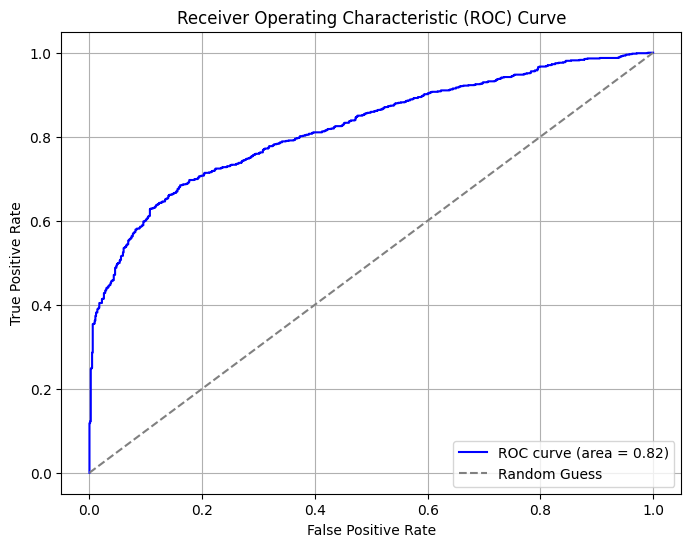

In [59]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probas[:, 1])

# Calculate AUC (optional but common)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [65]:
pd.DataFrame({"name" : model.feature_names_,
              "fi" : model.get_feature_importance()}).sort_values(by="fi", ascending=False)

,name,fi
1,CryoSleep,29.733231
0,HomePlanet,15.247128
10,sum_of_fees,11.549311
5,Cabin_1,10.428405
3,Age,9.800252
6,Cabin_3,5.540047
9,cabin_count,5.441442
2,Destination,5.354167
8,family_size,4.288474
7,group_count,2.055736


In [69]:
import mlflow

2025/08/08 14:25:24 INFO mlflow.tracking.fluent: Experiment with name 'Test Mlflow Notebook' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///c:/Users/a.ESSAKOURI/mlops_cicd/mlops-cicd/notebooks/mlruns/183277257266205382', creation_time=1754655924467, experiment_id='183277257266205382', last_update_time=1754655924467, lifecycle_stage='active', name='Test Mlflow Notebook', tags={}>

In [80]:
def compute_auc(y_true, y_pred_prob):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)

    return auc(fpr, tpr)

In [81]:
from mlflow.models import infer_signature



In [90]:
import mlflow.sklearn

mlflow.set_experiment(experiment_name="Test Mlflow Notebook")

with mlflow.start_run():
    model = CatBoostClassifier(cat_features=cat_feats, iterations=100)
    model.fit(x_train, y_train)

    y_pred_train = model.predict(x_train)
    y_pred_test = model.predict(x_test)

    y_pred_prob_train = model.predict_proba(x_train)[:,1]
    y_pred_prob_test = model.predict_proba(x_test)[:,1]

    metrics = {
        "acc_train" : accuracy_score(y_train, y_pred_train),
        "acc_test" : accuracy_score(y_test, y_pred_test),

        "f1_score_train" : f1_score(y_train, y_pred_train),
        "f1_score_test" : f1_score(y_test, y_pred_test),

        "auc_train" : compute_auc(y_train, y_pred_prob_train),
        "auc_test" : compute_auc(y_test, y_pred_prob_test)
    }

    signature = infer_signature(x_train, y_pred)

    mlflow.log_params(model.get_all_params())
    mlflow.log_metrics(metrics)

    mlflow.sklearn.log_model(model, signature=signature)

Learning rate set to 0.194791
0:	learn: 0.6452213	total: 33.5ms	remaining: 3.31s
1:	learn: 0.6167670	total: 77ms	remaining: 3.77s
2:	learn: 0.5980972	total: 117ms	remaining: 3.79s
3:	learn: 0.5819860	total: 153ms	remaining: 3.66s
4:	learn: 0.5673978	total: 187ms	remaining: 3.55s
5:	learn: 0.5585832	total: 227ms	remaining: 3.56s
6:	learn: 0.5501550	total: 262ms	remaining: 3.48s
7:	learn: 0.5444146	total: 297ms	remaining: 3.41s
8:	learn: 0.5385751	total: 352ms	remaining: 3.56s
9:	learn: 0.5336791	total: 391ms	remaining: 3.52s
10:	learn: 0.5270304	total: 427ms	remaining: 3.45s
11:	learn: 0.5260908	total: 442ms	remaining: 3.24s
12:	learn: 0.5247800	total: 480ms	remaining: 3.21s
13:	learn: 0.5212945	total: 523ms	remaining: 3.21s
14:	learn: 0.5170146	total: 559ms	remaining: 3.17s
15:	learn: 0.5142326	total: 603ms	remaining: 3.17s
16:	learn: 0.5132403	total: 644ms	remaining: 3.14s
17:	learn: 0.5117183	total: 702ms	remaining: 3.2s
18:	learn: 0.5101131	total: 750ms	remaining: 3.2s
19:	learn: 0.

2025/08/08 15:06:18 WARNING mlflow.models.signature: Failed to infer schema for inputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. Note that MLflow doesn't validate data types during inference for AnyType. To see the full traceback, set logging level to DEBUG.


In [88]:
model.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'Logloss',
 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'],
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'fold_permutation_block': 0,
 'leaf_estimation_method': 'Newton',
 'random_score_type': 'NormalWithModelSizeDecrease',
 'counter_calc_method': 'SkipTest',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'ctr_leaf_count_limit': 18446744073709551615,
 'bayesian_matrix_reg': 0.10000000149011612,
 'one_hot_max_size': 2,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': False,
 'max_ctr_complexity': 4,
 'model_size_reg': 0.5,
 'simple_ctr': ['Borders:CtrBorderCount=15:CtrBorder